In [1]:
%matplotlib inline

import os 
import time
import librosa
import IPython
import librosa.display
import importlib
import matplotlib
import numpy as np
import string as strp
import pr_util as util
import matplotlib.pyplot as plt

from scipy import signal, ndimage

importlib.reload(util)

<module 'pr_util' from '/Users/felipefelix/USP/tcc/code/pr_util.py'>

In [2]:
y, sr = librosa.load('Rexp/100041.filtered1.wav')
#y, sr = librosa.load('../dataset/pr_article/S_A_C_Base_Parte-1/Campephilus robustus/song/1000136.mp3.filtered1.wav')
IPython.display.Audio(data = y, rate = sr)

Quantidade de samples: 178432
Sample Rate: 22050


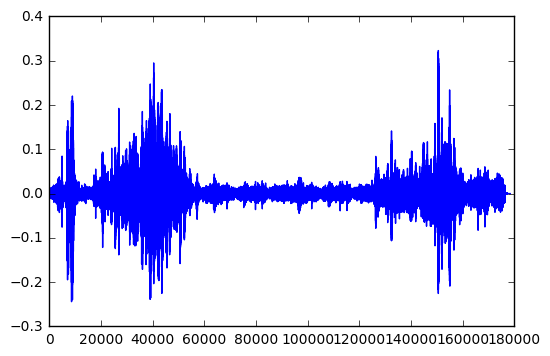

In [3]:
print('Quantidade de samples: {}'.format(len(y)))
print('Sample Rate: {}'.format(sr))
matplotlib.pyplot.plot(y)

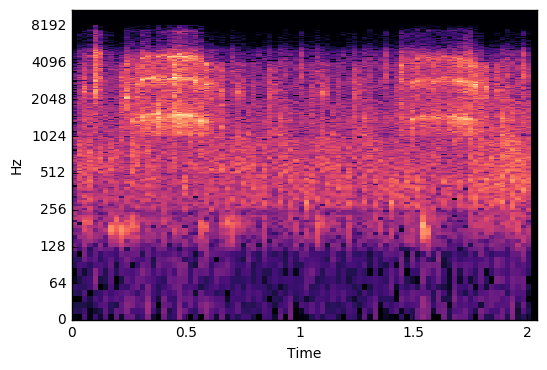

In [4]:
D = librosa.stft(y, n_fft= 2048, hop_length=2048)
D = librosa.amplitude_to_db(D, ref=np.max)

librosa.display.specshow(D, y_axis='log', x_axis='time')

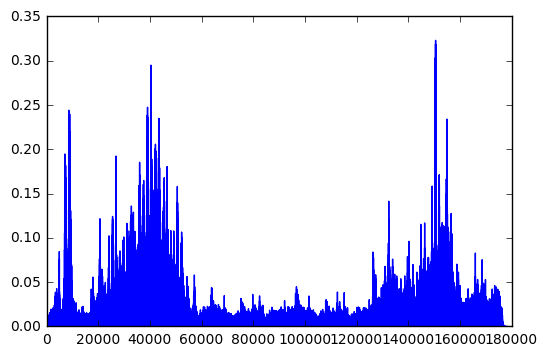

In [7]:
matplotlib.pyplot.plot(np.abs(y))

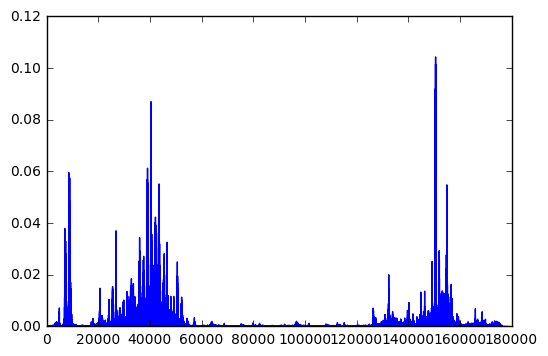

In [8]:
matplotlib.pyplot.plot(np.abs(y)**2)

In [9]:
def autodetec(y, power, thres, signal_or_change = 'signal'):
    N = len(y)
    y_env = np.abs(y) ** power
    y_new = y.copy()
    print('máximo do envelope {}'.format(np.max(y_env)))
    print('mínimo do envelope {}'.format(np.min(y_env)))
    print('média do envelope {}'.format(np.mean(y_env)))
    thres = np.mean(y_env) * 10
    y2 = np.zeros(N)
    menor = 0
    maior = 0
    
    for y in y_env:
        if y <= thres:
            menor += 1
        else:
            maior += 1
        
    y2[y_env <= thres] = 1
    y2[y_env  > thres] = 2

    print('pct menores: {}'.format(menor/(menor+maior)))
    print('pct maiores: {}'.format(maior/(menor+maior)))

    ## y3: { 2 = silence; 3 = change, 4 = signal}
    
    y3 = (y2[:-1] + y2[1:]).copy()
    
    y3[0] = 3
    y3[-1] = 3
    
    if signal_or_change == 'change':
        y_new[np.where(y3 != 3)[0]] = 0
        y_new[np.where(y3 == 3)[0]] = 1

        #return np.where(y3 == 3)[0]
        return y_new
    else:
        y_new[np.where(y3 != 4)[0]] = 0
        y_new[np.where(y3 == 4)[0]] = 1

        #return np.where(y3 == 4)[0]
        return y_new

#markers_on = autodetec(y, 2, 0.2)

In [47]:
y_new = autodetec(y, 2, 0.4, 'signal')

máximo do envelope 0.10433024168014526
mínimo do envelope 0.0
média do envelope 0.0005314408335834742
pct menores: 0.9787874372309899
pct maiores: 0.021212562769010044


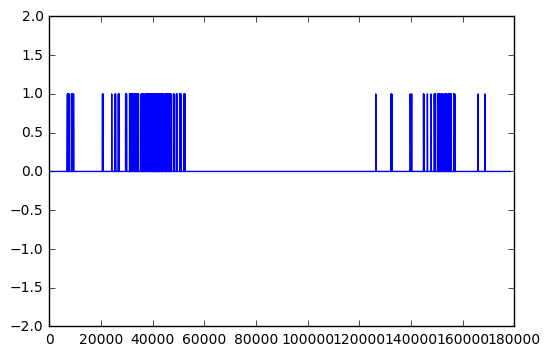

In [25]:
plt.ylim([-2,2])
plt.plot(y_new)

(73929, 98.017586416009706, 4.0, 1877.7174546756733, 1)


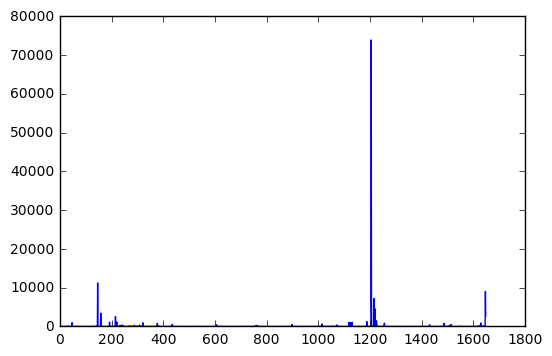

In [69]:
def estimate_struc_size(y):
    non_zeros = np.where(y == 1)[0]
    max_dis = -np.inf
    dis = []
    for i in range(len(non_zeros) - 1):
        current_dis = non_zeros[i + 1] - non_zeros[i]
        #if current_dis > 500:
        dis += [current_dis]
    plt.plot(dis)
    return np.max(dis), np.mean(dis), np.median(dis), np.std(dis), np.min(dis)
print(estimate_struc_size(y_new))

quantidade de 1's no vetor original: 1650.0
quantidade de 1's no vetor filtrado: 551.0


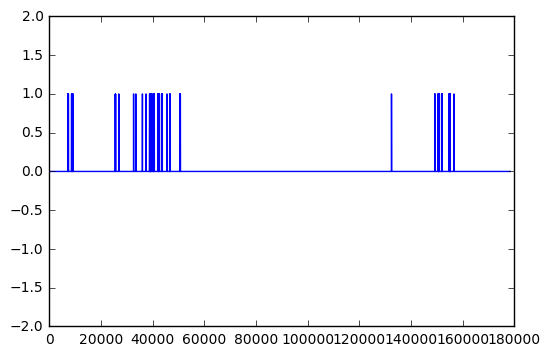

In [273]:
# Teste com o filtro da mediana
# Em geral, o filtro cria mais 0's do que 1's.

y_filtered = y_new.copy()
non_zero = np.where(y_new != 0)[0]
N = len(y_filtered)

#for i in non_zero:
#    if i + 10 < N:
#        if (np.mean(y_filtered[i:i + 10]) >= 0.5):
#            y_filtered[i:i + 10] = signal.medfilt(y_filtered[i:i + 10], 9)

y_filtered = signal.medfilt(y_filtered, 5)

print("quantidade de 1's no vetor original: {}".format(np.sum(y_new)))
print("quantidade de 1's no vetor filtrado: {}".format(np.sum(y_filtered)))

plt.ylim([-2,2])
plt.plot(y_filtered)
#plt.plot(np.logical_or(y_filtered, y_new ))

In [51]:
struc_size = 7501*2
half_size = int(struc_size/2)
struc_l = np.array([1] * struc_size)
struc_l[:half_size] = 0

struc_r = np.array([1] * struc_size)
struc_r[half_size:] = 0


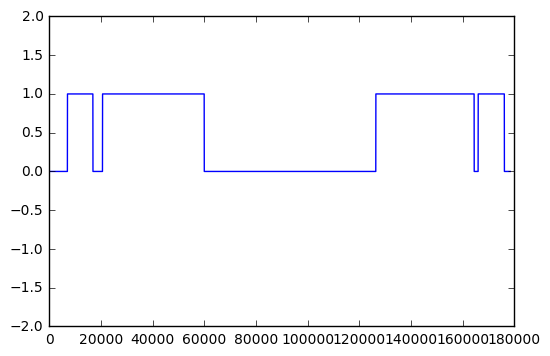

In [52]:
y_filtered_l = ndimage.morphology.binary_dilation(y_new, struc_l)

plt.ylim([-2,2])
plt.plot(y_filtered_l)

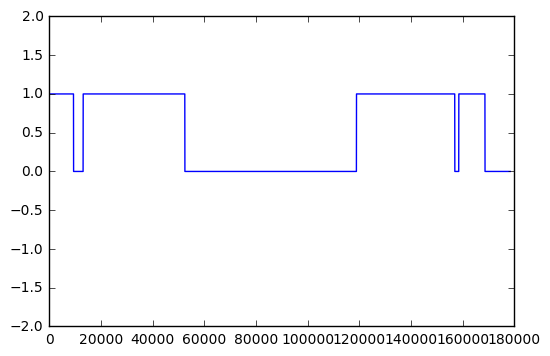

In [54]:
y_filtered_r = ndimage.morphology.binary_dilation(y_new, struc_r)

plt.ylim([-2,2])
plt.plot(y_filtered_r)

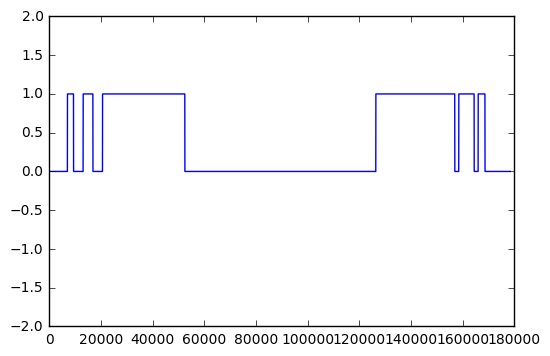

In [55]:
y_filtered = np.logical_and(y_filtered_l, y_filtered_r)

plt.ylim([-2,2])
plt.plot(y_filtered)

In [58]:
# OLD
#struc_size = 7501
#struc = [1] * struc_size
    
#y_filtered = ndimage.morphology.binary_dilation(y_new, struc)

#print("tamanho do elemento estruturante: {}".format(struc_size))
#print("duração do elemento struturante: {}".format(util.samples_to_time(struc_size, sr)))
#print("quantidade de 1's no vetor original: {}".format(np.sum(y_new)))
#print("quantidade de 1's no vetor filtrado: {}".format(np.sum(y_filtered)))

#plt.ylim([-2,2])
#plt.plot(y_filtered)

In [19]:
def durations_syllable(y):
    durations = []
    N = len(y)
    i = 0
    init = 0
    end = 0
    syllable = y[0] == 1
    
    while (i < N):
        if (y[i] == 1 and not syllable):
            init = i
            syllable = True
        if (y[i] == 0 and syllable):
            end = i - 1
            durations += [end - init]
            syllable = False
        i += 1
    return durations

def filter_durations(durations, dur_min, dur_max):
    return [dur for dur in durations if dur < dur_max and dur > dur_min]

def fix_durations(durations, struc):
    size_struc = len(struc)
    return [dur - (int(size_struc/2) - 1) for dur in durations]

In [17]:
y_play = y[y_filtered]
IPython.display.Audio(data = y_play, rate = sr)

In [57]:
durations = durations_syllable(y_filtered)
print('Antes de filtrar: {}'.format(durations))
#durations = fix_durations(durations, struc)
durations = filter_durations(durations, util.time_to_samples(0.5, sr), util.time_to_samples(3, sr))
print('Depois da filtragem e ajuste: {}'.format(durations))
print("tamanho médio das sílabas em samples: {}".format(np.mean(durations)))
print('Tamanho das sílabas: {}, {}'.format(util.samples_to_time(durations[0], sr), util.samples_to_time(durations[1], sr)))
print('Tamanho das sílabas ground-truth: 1.648s, 1.264')
print('Média das sílabas: {}'.format(util.samples_to_time(np.mean(durations), sr)))
print('Média das sílabas ground-truth: 1.456')

Antes de filtrar: [2363, 3782, 31868, 30559, 5951, 2639]
Depois da filtragem e ajuste: [31868, 30559]
tamanho médio das sílabas em samples: 31213.5
Tamanho das sílabas: 1.4452607709750567, 1.3858956916099774
Tamanho das sílabas ground-truth: 1.648s, 1.264
Média das sílabas: 1.415578231292517
Média das sílabas ground-truth: 1.456


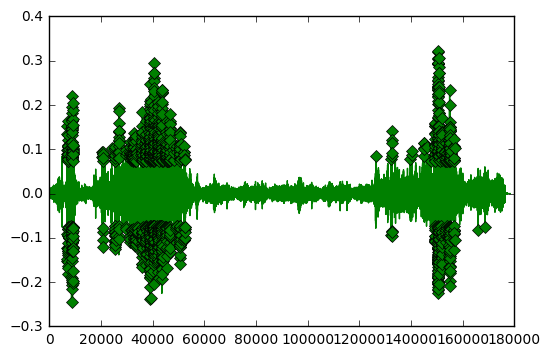

In [76]:
plt.plot(y, '-gD', markevery = markers_on.tolist())

In [9]:
def plot_with_marks(y, power, thres, n_fft, signal_or_change = 'signal', save_pic = False):
    markers_on = autodetec(y, power, thres, signal_or_change)
    markers_on = markers_on.tolist()
    D = librosa.stft(y, hop_length = n_fft, n_fft = n_fft)
    #print(D.shape)
    #print(np.max(D))
    D = librosa.amplitude_to_db(D, ref=np.max)
    print(D.shape)
    M, N = D.shape
    #print(np.min(D))
    
    for frame in markers_on:
        #print(int(np.floor(frame/n_fft)))
        D[:int(M/20), int(np.floor(frame/n_fft))] = 10
        
    #D[:,200] = -80
    librosa.display.specshow(D, y_axis='log', x_axis='time')
    plt.title('Power spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    if (save_pic): plt.savefig("../pics/file.power_{}.thres_{}.nfft_{}.svg".format(power, thres, n_fft))
    return markers_on


#plot_with_marks(y, 2, 0.2, 2048)

máximo do envelope 0.3230019211769104
mínimo do envelope 0.0
média do envelope 0.012780209071934223
pct menores: 0.9959592449784792
pct maiores: 0.004040755021520803
(1025, 88)


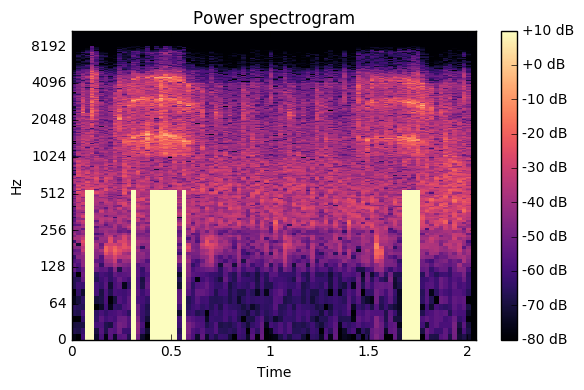

In [78]:
y, sr = librosa.load('Rexp/100041.filtered1.wav')
markers = plot_with_marks(y, 1, 0.07, 2048)

In [5]:
def syllable_durations(markers_original, max_dur):
    markers = markers_original.copy()
    markers.append(np.inf)
    N = len(markers)
    #print("N: {}".format(N))
    durations = []
    init = 0
    while (init < N):
        end = init + 1
        #print("first init: {} end: {}".format(init, end))
        while (end < N):
            if (markers[end] - markers[init] > max_dur):
                if (init != end - 1):
                    durations.append(markers[end - 1] - markers[init])
                # init = end
                # print("if init: {} end: {}".format(init, end))
                if end + 1 == N:
                    #print("era pra ter acabado")
                    init = N + 1
                else:
                    init = end
                break
            end += 1
        #print(durations)
    return durations

#print(syllable_durations([23,24,25,80,82,84], 2))
#print(syllable_durations([0, 3, 4, 23, 24, 25, 1453, 1456, 1458, 1467, 8001, 8009, 8030], 15))


In [7]:
file_dirs = util.return_random_audio(util.choose_species(1))
print(file_dirs)


['/Users/felipefelix/USP/tcc/dataset/pr_article/S_A_C_Base_Parte-3/Ramphastos dicolorus/song/TOUCAN%20Red-breasted_01_Retiro%20S.mp3', '/Users/felipefelix/USP/tcc/dataset/pr_article/S_A_C_Base_Parte-3/Ramphastos dicolorus/song/TOUCAN%20Red-breasted_01_Retiro%20S.mp3.filtered1.wav', '/Users/felipefelix/USP/tcc/dataset/pr_article/S_A_C_Base_Parte-3/Ramphastos dicolorus/song/TOUCAN%20Red-breasted_01_Retiro%20S.mp3.filtered2.wav']


In [80]:
IPython.display.Audio(file_dirs[0])

máximo do envelope 0.8095889091491699
mínimo do envelope 0.0
média do envelope 0.018776658922433853
pct menores: 0.9842925026399155
pct maiores: 0.015707497360084477
(1025, 267)
[24746, 24747, 24751, 24752, 24756, 24757, 24761, 24762, 24763, 24767, 24768, 24778, 24779, 24784, 24785, 24994, 24999, 25004, 25005, 25010, 25011, 25021, 25022, 25027, 25028, 25038, 25237, 25238, 25242, 25243, 25247, 25248, 25252, 25253, 25254, 25257, 25258, 25259, 25263, 25264]


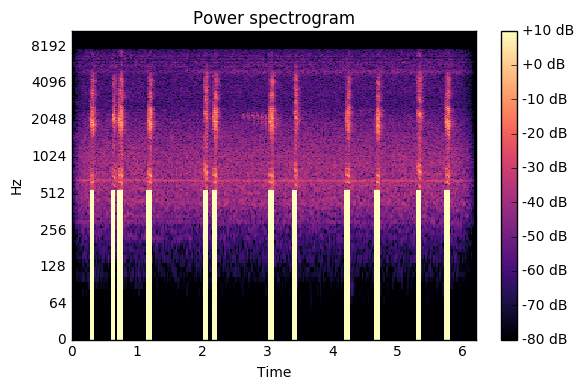

In [10]:
y, sr = librosa.load(file_dirs[0])
markers = plot_with_marks(y, 1, 0.07, 2048, 'signal')
print(markers[:40])

máximo do envelope 0.8095889091491699
mínimo do envelope 0.0
média do envelope 0.018776658922433853
pct menores: 0.9842925026399155
pct maiores: 0.015707497360084477
(1025, 267)


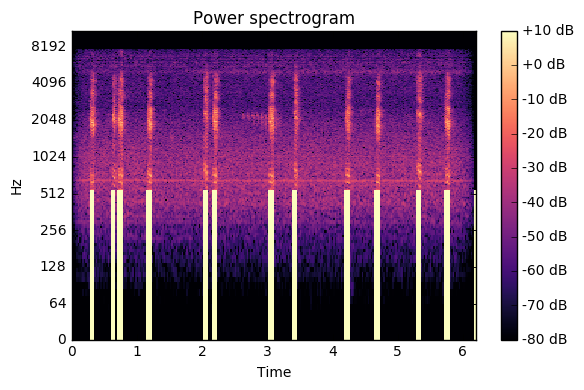

In [11]:
y, sr = librosa.load(file_dirs[0])
markers = plot_with_marks(y, 1, 0.07, 2048, 'change')

In [83]:
IPython.display.Audio(file_dirs[1])

máximo do envelope 0.41923630237579346
mínimo do envelope 0.0
média do envelope 0.004208381287753582
pct menores: 0.9709562059859155
pct maiores: 0.029043794014084506
(1025, 267)


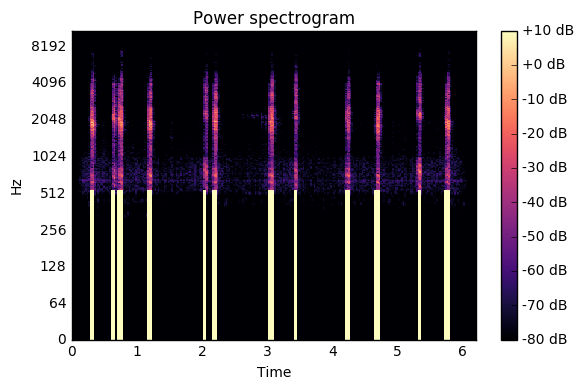

In [12]:
y, sr = librosa.load(file_dirs[1])
markers = plot_with_marks(y, 1, 0.01, 2048, 'signal')

máximo do envelope 0.41923630237579346
mínimo do envelope 0.0
média do envelope 0.004208381287753582
pct menores: 0.9709562059859155
pct maiores: 0.029043794014084506
(1025, 267)


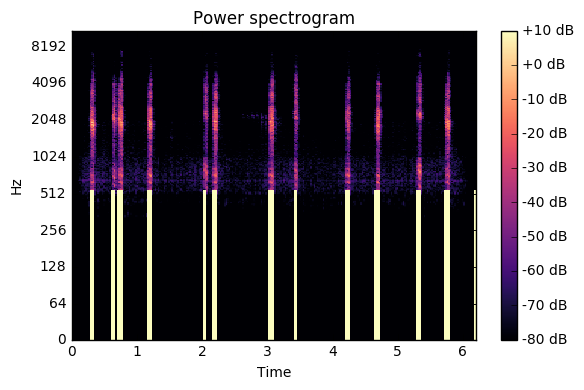

In [13]:
y, sr = librosa.load(file_dirs[1])
markers = plot_with_marks(y, 1, 0.01, 2048, 'change')

In [14]:
#print(markers[:1000])

for i in range(100, 3000, 100):
    durations = syllable_durations(markers, i)
    print(i)
    print(np.mean(durations))


100
77.5608591885
200
144.400793651
300
269.011904762
400
349.984615385
500
460.137614679
600
525.655913978
700
609.580246914
800
713.757142857
900
800.5
1000
866.483333333
1100
957.833333333
1200
1021.82352941
1300
1111.46808511
1400
1219.46511628
1500
1253.16666667
1600
1276.87804878
1700
1308.85
1800
1504.91428571
1900
1491.08571429
2000
1668.6875
2100
1767.8
2200
1784.43333333
2300
1839.06896552
2400
1833.48275862
2500
1843.86206897
2600
1965.14814815
2700
2239.45833333
2800
2221.58333333
2900
2229.91666667


In [132]:
pitches, magnitudes = librosa.core.piptrack(y = y, sr = sr)

In [120]:
print(np.max(pitches))
print(np.mean(pitches[pitches != 0]))
pond = pitches * magnitudes
print(np.mean(pond[pond != 0]))
print(pitches.shape)
print(np.mean(pitches, axis=1))


3999.51
2350.91
601.506
(1025, 689)
[ 0.  0.  0. ...,  0.  0.  0.]


In [110]:
a = np.array([[1, 2], [5, 3]])
print(a)
print(np.mean(a))
print(np.mean(a, axis=0))
print(np.mean(a, axis=1))

[[1 2]
 [5 3]]
2.75
[ 3.   2.5]
[ 1.5  4. ]


In [139]:
means = np.mean(pitches, axis = 1)
print(np.max(means))
print(np.where(means == np.max(means)))
print(np.mean(pitches, axis = 1))
for p in pitches[:, 329]:
    print(p)
print(pitches[:,444])


681.398
(array([323]),)
[ 0.  0.  0. ...,  0.  0.  0.]
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
313.857
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
423.534
0.0
0.0
0.0
0.0
470.143
0.0
0.0
0.0
0.0
0.0
0.0
546.317
0.0
0.0
579.925
0.0
601.96
0.0
623.933
0.0
0.0
0.0
669.823
0.0
0.0
0.0
0.0
0.0
730.712
0.0
752.17
0.0
0.0
0.0
0.0
803.265
0.0
829.482
0.0
855.351
0.0
0.0
0.0
0.0
0.0
0.0
0.0
935.296
0.0
0.0
0.0
0.0
0.0
1001.25
0.0
0.0
1032.32
0.0
0.0
1066.83
0.0
0.0
0.0
1109.41
0.0
0.0
1137.03
0.0
0.0
1169.14
0.0
0.0
0.0
0.0
1223.68
0.0
0.0
1262.37
0.0
0.0
0.0
0.0
1312.21
0.0
0.0
1342.77
0.0
0.0
0.0
0.0
1401.37
0.0
0.0
1431.97
0.0
1454.3
0.0
0.0
1482.73
0.0
0.0
1517.52
0.0
0.0
1555.0
0.0
0.0
0.0
1596.41
0.0
0.0
0.0
0.0
1648.43
0.0
0.0
1676.09
0.0
0.0
1711.64
0.0
0.0
1742.09
0.0
0.0
0.0
0.0
1793.29
0.0
1817.86
0.0
0.0
1856.0
0.0
0.0
1880.78
0.0
1902.57
0.0
1931.9
0.0
0.0
1955.96
0.0
0.0
1996.4
0.0
0.0
0.0
2034.3
0.0
0.0
0.0
2078.

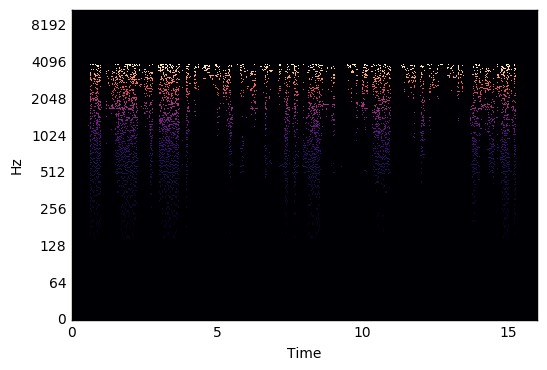

In [141]:
librosa.display.specshow(pitches, y_axis='log', x_axis='time')

(1025, 689)
(24138,)
[ 0.02624403  0.04004943  0.04341374 ...,  1.09214699  1.48136997
  0.43121156]


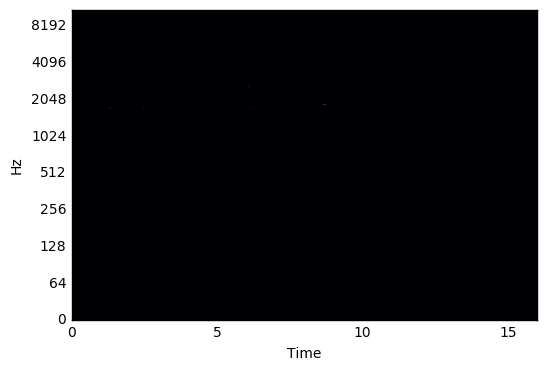

In [134]:
pond = pitches * magnitudes
print(pond.shape)
print(pond[pond != 0].shape)
print(pond[pond != 0])

librosa.display.specshow(pond, y_axis='log', x_axis='time')

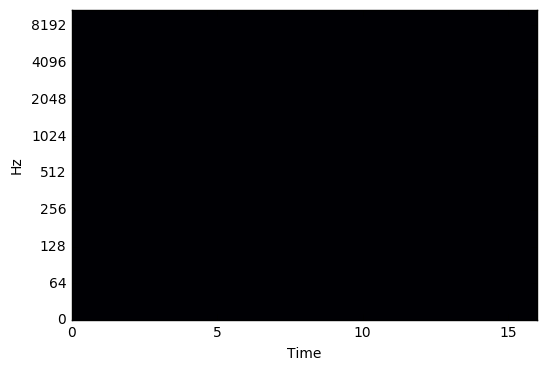

In [144]:
librosa.display.specshow(magnitudes, y_axis='log', x_axis='time')